### Neurala Nätverk är modeller för Allmän Linjär Regression 

<img src="../Data/mlpnn.jpg">

Ŷ = φ (XW + b)

att jämföra med

$\hat{Y} = \beta_0 + \beta_1X_1 …$

Varje $x_i w_{ij} + b_i$ är alltså en linje! Om aktiveringsfunktionen är linjär, så är hela systemet verkligen "bara" en multipel linjär regression.

### Ickelinjäritet

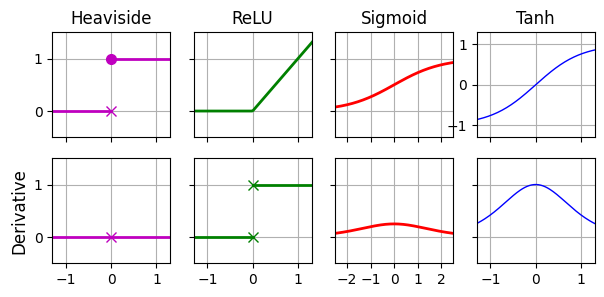

In [48]:
# activation functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 2.5
z = np.linspace(-max_z, max_z, 200)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3))

axes[0, 0].plot([-max_z, 0], [0, 0], "m-", linewidth=2)
axes[0, 0].plot(0, 0, "mx", markersize=7)
axes[0, 0].plot(0, 1, "mo", markersize=7)
axes[0, 0].plot([0, max_z], [1, 1], "m-", linewidth=2)
axes[0, 0].set_title("Heaviside", fontsize=12)
axes[1, 0].plot(z, derivative(np.sign, z), "m-", linewidth=2)
axes[1, 0].plot(0, 0, "mx", markersize=7)
axes[1, 0].set_ylabel("Derivative", fontsize=12)

axes[0, 1].plot(z, relu(z), "g-", linewidth=2)
axes[0, 1].set_title("ReLU", fontsize=12)
axes[1, 1].plot([-max_z, 0], [0, 0], "g-", linewidth=2)
axes[1, 1].plot([0, max_z], [1, 1], "g-", linewidth=2)
axes[1, 1].plot(0, 0, "gx", markersize=7)
axes[1, 1].plot(0, 1, "gx", markersize=7)

axes[0, 2].plot(z, sigmoid(z), "r-", linewidth=2)
axes[0, 2].set_title("Sigmoid", fontsize=12)
axes[1, 2].plot(z, derivative(sigmoid, z), "r-", linewidth=2)

axes[0, 3].plot(z, np.tanh(z), "b-", linewidth=1)
axes[0, 3].set_title("Tanh", fontsize=12)
axes[1, 3].plot(z, derivative(np.tanh, z), "b-", linewidth=1)

for row in range(2):
    for col in range(4):
        axes[row, col].grid(True)
        if row == 0:
            axes[row, col].set_xticklabels([])
        if col == 2:
            axes[row, col].set_xlim(-max_z, max_z)
            axes[row, col].set_xticks([-2, -1, 0, 1, 2])
        else:
            axes[row, col].set_xlim(-1.3, 1.3)
            axes[row, col].set_xticks([-1, 0, 1])
        if col != 0 and ((row, col) != (0, 3)):
            axes[row, col].set_yticklabels([])
        if (row, col) == (0, 3):
            axes[row, col].set_ylim(-1.3, 1.3)
            axes[row, col].set_yticks([-1, 0, 1])
        else:
            axes[row, col].set_ylim(-0.5, 1.5)
            axes[row, col].set_yticks([0, 1])

plt.show()



Men vi löser inte detta system med statistisk anpassning. Inte minst kan vi inte hantera diskontinuerliga aktiveringsfunktioner med OLS eller MLE! Med numeriska närmevärden kommer vi undan detta, vilket är matematisk krångligt men praktiskt bekvämt.

Idéen är på ytan enkel, men matematiskt väldigt svårbegriplig! Se Appendix A i boken -- matematiken är mer än vi klarar med algebran vi lärt oss. Framör allt måste vi använda hyperkomplexa tal (_dualer_). För den hugade som inte är rädd för abstrakt algebra har Dr [Michael Penn](https://www.youtube.com/watch?v=ceaNqdHdqtg) en video om dem. Det finns andra enklare videor på youtube, men de begrepp som Dr Penn går igenom är det som faktiskt krävs för att kunna använda dem på egen hand.

I korta; dualer är en sorts tal som har "fler nollor" än vanliga tal. Specifikt finns en särskild symbol $\epsilon$ som har egenskapen $\epsilon^2 = 0$ (jämför med komplexa tal $i^2 = -1$).


<small>Överkurs <br />
En formulering i linjär algebra:
Icke-linjäritet leder till att nollrummets dimension exploderar; det finns alltså fler och fler icke-lösningar. Detta innebär att Jordan dekompositionen inte längre skulle vara nilpotent och vi hamnar i "curse of dimensionality", dvs hittar bara icke-lösningar. Med dualer avbildar vi nollrummet på ett delrum som är nilpotent! Därmed kan vi derivera även icke-kontinuerliga aktiveringsfunktioner, och hitta linjära approximationer till vad som helst i ett litet område kring testdatan! Vi kan till och med formulera det som Taylor-expansion och återsälla Kolmogorovs representationsteorem --> Universal Approximation Theorem för feed-forward NN.
</small>

Istället för att beräkna lutningen på alla linjerna separat, så uppskattar vi lutningarna (vikterna $w_{ij}$) för alla noder på en gång. Detta sker genom två pass genom nätverket: 
* I framåt riktningen beräknas alla noders värden (dvs $x_iw_{ij} + b_i$)
* I bakåt riktningen beräknas de partiella derivatorna för hela det multipla linjära systemet genom en hyperkomplex beräkningsgraf

Detta kallas <em>reverse-mode auto-diff</em>.

Nästa steg för att få en fungerande algoritm för att träna ett NN är att utföra <em>gradient descent</em>, dvs: 
* Justera vikterna $w_{ij}$ ett litet steg i den beräknade gradientens riktning. 

Upprepa!

När vi når något stopp-villkor så är vi klara. Detta kallas 'backpropagation'.

Notera att inget sades om vilken <em>sorts</em> gradient descent som används. I praktiken är <em>mini-batch gradient descent</em> det som är effektivast att köra på GPUer, men särskilt på CPU kan en sann stokastisk gradient descent (där vi alltså sätter någon sannolikhet för varje nod att vara med eller inte) vara lämplig. Detta är mindre sannolikt idag, eftersom även CPUer är väldigt parallella med dussintals, eller till och med hundratals, processorkärnor. 


Modern hårdvara är riktigt snabb, både CPU och GPU. På en AMD 7800X3D/7900GRE (en speldator som är en generation gammal och i näst högsta klassen av den generationens hårdvara) så är prestandan 8x högre för CPU och 4x snabbare för GPU än en gratisinstans på Colab (nVidia T4).

In [49]:
import torch
device = "cuda"

In [50]:
M = torch.rand((1000,1000))
M @ M.T # uppvärming; låter X3D cachen på CPU fyllas
%timeit M @ M.T

M = M.to(device)
M @ M.T # låter GDDR-cache på GPU fyllas
%timeit M @ M.T

2.07 ms ± 64.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
143 μs ± 10.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Att jämföra med Colab: <br />
16.1 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)<br /> 
549 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Notera att AMD/ROCM exekverar annorlunda: 10x fler loopar som var och en tar längre tid men totalt är 7900GRE mycket snabbare än en T4 (och halva priset).

Sklearn har enklare neurala nätverk, men de är ganska begränsade. Däremot är de väldigt optimerade och förkompilerade, så de prestrerar ofta bra. Låt oss undersöka dem först, och sedan börja implementera samma sak fast med pytorch. 

In [51]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [52]:
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)

In [53]:
housing.feature_names, housing.target_names

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 ['MedHouseVal'])

In [54]:
# in och ut dimensioner räknas ut automatiskt! ReLU mellan dolda lager, linjärt ut och in
# early stopping för att undvika overfit
mlp_reg = MLPRegressor(hidden_layer_sizes=[50,50,50], early_stopping=True, verbose=True)

In [55]:
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Iteration 1, loss = 1.16651883
Validation score: 0.455249
Iteration 2, loss = 0.31197862
Validation score: 0.618217
Iteration 3, loss = 0.23624361
Validation score: 0.683293
Iteration 4, loss = 0.20754655
Validation score: 0.707283
Iteration 5, loss = 0.19458900
Validation score: 0.716941
Iteration 6, loss = 0.18766063
Validation score: 0.719259
Iteration 7, loss = 0.18077074
Validation score: 0.728189
Iteration 8, loss = 0.17935314
Validation score: 0.734345
Iteration 9, loss = 0.17293732
Validation score: 0.736635
Iteration 10, loss = 0.16990311
Validation score: 0.740521
Iteration 11, loss = 0.16869121
Validation score: 0.742902
Iteration 12, loss = 0.17136664
Validation score: 0.743726
Iteration 13, loss = 0.16870836
Validation score: 0.748731
Iteration 14, loss = 0.16198107
Validation score: 0.750768
Iteration 15, loss = 0.15892808
Validation score: 0.755198
Iteration 16, loss = 0.15772358
Validation score: 0.756119
Iteration 17, loss = 0.15664446
Validation score: 0.757529
Iterat

,steps,"[('standardscaler', ...), ('mlpregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"[50, 50, ...]"
,activation,'relu'
,solver,'adam'


In [56]:
mlp_reg.best_validation_score_

0.7927395292725832

In [57]:
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

In [58]:
rmse

0.49868586564444217

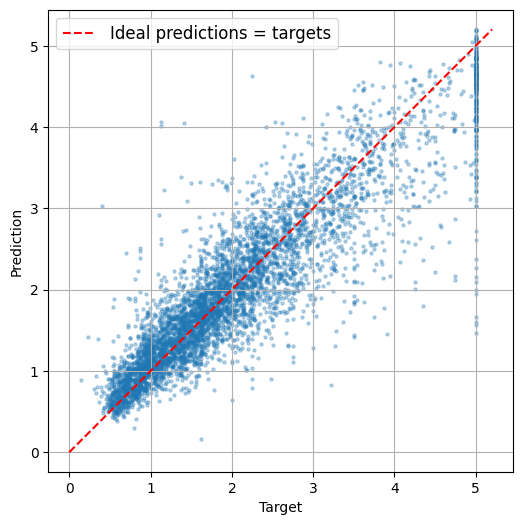

In [59]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
plt.plot([0, 5.2], [0,5.2], color='red', linestyle='--', label="Ideal predictions = targets")
plt.axis("equal")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Backpropagation i Torch

#### Autograd, reverse-mode autodiff i pytorch



$f(x) = x^2$

$f(5) = 25$

$f'(x) = 2x$

$f'(5) = 10$

In [60]:
x = torch.tensor(5.0, requires_grad=True)
f = x ** 2
f

tensor(25., grad_fn=<PowBackward0>)

In [61]:
f.backward() # reverse-mode auto-diff
x.grad # f och x är kopplade tack vare requires_grad!

tensor(10.)

#### Backpropagation

In [62]:
learning_rate = 0.1 # hur stort steg vi tar
x = torch.tensor(5.0, requires_grad=True)
for iteration in range(100):
    f = x**2 # framåt passet, beräkna alla värden
    f.backward() # bakåtpasset genom beräkningsgrafen
    # gradient descent
    with torch.no_grad(): # koppla inte till gradienterna! vi vill räkna om dem senare
        x -= learning_rate * x.grad
    x.grad.zero_() # sätt gradienterna till 0 så vi räknar om från början



In [63]:
x # går mot 0, eftersom x^2 har sitt minimum där!

tensor(1.0185e-09, requires_grad=True)

### Linjär regression med pytorch

In [64]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)
print(f"Training set: {X_train.shape, y_train.shape}\nTest set: {X_test.shape, y_test.shape}")

Training set: ((15480, 8), (15480,))
Test set: ((5160, 8), (5160,))


In [65]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
means = X_train.mean(dim = 0, keepdim=True)
stds = X_train.std(dim=0, keepdims=True)
X_train = (X_train - means) / stds
X_test = (X_test - means) / stds

In [66]:
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)


In [67]:
n_features = X_train.shape[1]
w = torch.randn((n_features, 1), requires_grad=True) # initialisera med slumpässiga vikter
b = torch.tensor(0., requires_grad=True)


##### Batch Gradient Descent

In [68]:
learning_rate = 0.1
n_epochs = 100
for epoch in range(n_epochs):
    y_pred = X_train @ w + b
    loss = ((y_pred - y_train)**2).mean() # MSE
    loss.backward()
    with torch.no_grad():
        b -= learning_rate * b.grad
        w -= learning_rate * w.grad
        b.grad.zero_()
        w.grad.zero_()
    print(f"Epoch {epoch +1}/{n_epochs}, Loss: {loss.item()}")


Epoch 1/100, Loss: 11.247909545898438
Epoch 2/100, Loss: 6.2520432472229
Epoch 3/100, Loss: 3.8326666355133057
Epoch 4/100, Loss: 2.5790555477142334
Epoch 5/100, Loss: 1.886907696723938
Epoch 6/100, Loss: 1.4836182594299316
Epoch 7/100, Loss: 1.2383852005004883
Epoch 8/100, Loss: 1.0842009782791138
Epoch 9/100, Loss: 0.9845616221427917
Epoch 10/100, Loss: 0.9185320138931274
Epoch 11/100, Loss: 0.8736276030540466
Epoch 12/100, Loss: 0.8421924710273743
Epoch 13/100, Loss: 0.8194432258605957
Epoch 14/100, Loss: 0.8023519515991211
Epoch 15/100, Loss: 0.7889847755432129
Epoch 16/100, Loss: 0.778099000453949
Epoch 17/100, Loss: 0.7688910365104675
Epoch 18/100, Loss: 0.7608394622802734
Epoch 19/100, Loss: 0.7536033391952515
Epoch 20/100, Loss: 0.7469590902328491
Epoch 21/100, Loss: 0.7407586574554443
Epoch 22/100, Loss: 0.7349033355712891
Epoch 23/100, Loss: 0.7293265461921692
Epoch 24/100, Loss: 0.7239828109741211
Epoch 25/100, Loss: 0.7188403010368347
Epoch 26/100, Loss: 0.7138767242431641


In [69]:
with torch.no_grad():
    y_pred = X_test @ w + b
    

In [70]:
root_mean_squared_error(y_test, y_pred)

0.7264852523803711

#### Direkt med pytorch

In [71]:
import torch.nn as nn
model = nn.Linear(in_features=n_features, out_features=1)


In [72]:
model.bias

Parameter containing:
tensor([0.1714], requires_grad=True)

In [73]:
model.weight

Parameter containing:
tensor([[-0.1733, -0.3413, -0.2419, -0.3125,  0.1791, -0.1833, -0.3392,  0.1653]],
       requires_grad=True)

In [74]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.1733, -0.3413, -0.2419, -0.3125,  0.1791, -0.1833, -0.3392,  0.1653]],
       requires_grad=True)
Parameter containing:
tensor([0.1714], requires_grad=True)


In [75]:
model(X_train[:2])

tensor([[0.6369],
        [0.3632]], grad_fn=<AddmmBackward0>)

In [76]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

mse = nn.MSELoss()

In [77]:
def train_bgd(model, optimizer, criterion, X_train, y_train, n_epochs):
    for epoch in range(n_epochs):
        y_pred = model(X_train) # hela träningssettet, alltså Batch Gradient Descent
        loss = criterion(y_pred, y_train) # optimeringsvillkor, kostnadsfunktion, loss function
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")


In [78]:
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs)

Epoch 1/100, Loss: 6.065733432769775
Epoch 2/100, Loss: 3.9096360206604004
Epoch 3/100, Loss: 2.6628928184509277
Epoch 4/100, Loss: 1.9110053777694702
Epoch 5/100, Loss: 1.444869041442871
Epoch 6/100, Loss: 1.1506849527359009
Epoch 7/100, Loss: 0.9627633094787598
Epoch 8/100, Loss: 0.8416047096252441
Epoch 9/100, Loss: 0.7628259062767029
Epoch 10/100, Loss: 0.7111296653747559
Epoch 11/100, Loss: 0.6768234372138977
Epoch 12/100, Loss: 0.6537283658981323
Epoch 13/100, Loss: 0.6378887295722961
Epoch 14/100, Loss: 0.6267651319503784
Epoch 15/100, Loss: 0.6187224388122559
Epoch 16/100, Loss: 0.6127058267593384
Epoch 17/100, Loss: 0.6080325841903687
Epoch 18/100, Loss: 0.6042600870132446
Epoch 19/100, Loss: 0.6010999083518982
Epoch 20/100, Loss: 0.5983636379241943
Epoch 21/100, Loss: 0.5959274768829346
Epoch 22/100, Loss: 0.5937097072601318
Epoch 23/100, Loss: 0.591655969619751
Epoch 24/100, Loss: 0.5897296071052551
Epoch 25/100, Loss: 0.587905764579773
Epoch 26/100, Loss: 0.5861673951148987

In [79]:
with torch.no_grad():
    y_pred = model(X_test)
root_mean_squared_error(y_test, y_pred)

0.7133892178535461

In [80]:
model = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=50),nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 1))

optimizer = torch.optim.Adam(model.parameters())
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs*10)
with torch.no_grad():
    y_pred = model(X_test)


Epoch 1/1000, Loss: 5.460391521453857
Epoch 2/1000, Loss: 5.404046058654785
Epoch 3/1000, Loss: 5.3484110832214355
Epoch 4/1000, Loss: 5.292983055114746
Epoch 5/1000, Loss: 5.236898422241211
Epoch 6/1000, Loss: 5.179238796234131
Epoch 7/1000, Loss: 5.119048595428467
Epoch 8/1000, Loss: 5.055455207824707
Epoch 9/1000, Loss: 4.987316131591797
Epoch 10/1000, Loss: 4.913143634796143
Epoch 11/1000, Loss: 4.83172607421875
Epoch 12/1000, Loss: 4.742115497589111
Epoch 13/1000, Loss: 4.6435546875
Epoch 14/1000, Loss: 4.5351643562316895
Epoch 15/1000, Loss: 4.416497707366943
Epoch 16/1000, Loss: 4.2870683670043945
Epoch 17/1000, Loss: 4.1461615562438965
Epoch 18/1000, Loss: 3.9931607246398926
Epoch 19/1000, Loss: 3.8278298377990723
Epoch 20/1000, Loss: 3.6504154205322266
Epoch 21/1000, Loss: 3.4618725776672363
Epoch 22/1000, Loss: 3.263681173324585
Epoch 23/1000, Loss: 3.057713031768799
Epoch 24/1000, Loss: 2.8463940620422363
Epoch 25/1000, Loss: 2.6328370571136475
Epoch 26/1000, Loss: 2.4212450

In [81]:
root_mean_squared_error(y_test, y_pred)


0.5264604091644287

### Klassificering

In [82]:
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="fashion-mnist", as_frame=False, parser="liac-arff")
targets = fashion_mnist.target.astype(int)


In [83]:
X_train, y_train = fashion_mnist.data[:60_000], targets[:60_000]
X_test , y_test = fashion_mnist.data[60000:], targets[60000:]

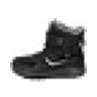

In [84]:
X_sample = X_train[0].reshape(28,28)
plt.figure(figsize=(1,1))
plt.imshow(X_sample, cmap="binary")
plt.axis('off')
plt.show()

In [85]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [86]:
class_names[y_train[0]]

'Ankle boot'

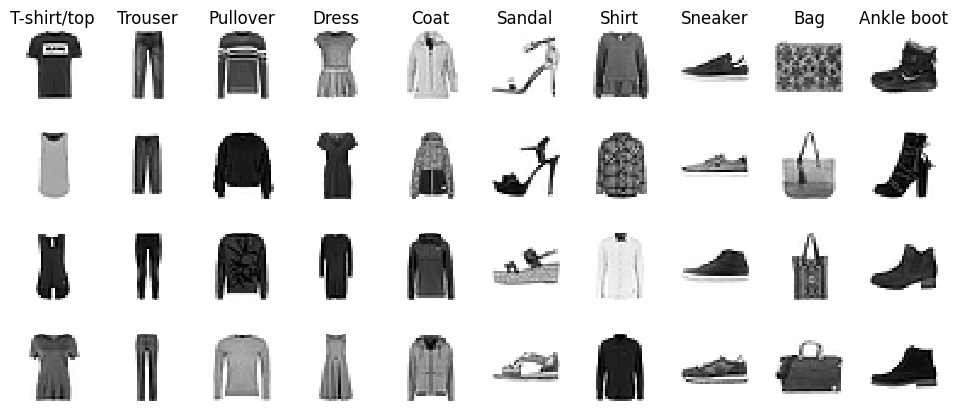

In [87]:
n_rows = 4
plt.figure(figsize=(12, n_rows*1.2))
for row in range(n_rows):
    for class_index in range(10):
        X_img = X_train[y_train==class_index][row].reshape(28, 28)
        y_img = y_train[y_train==class_index][row]
        plt.subplot(n_rows, 10, 10 *row + class_index + 1)
        plt.imshow(X_img, cmap="binary", interpolation="nearest")
        plt.axis('off')
        if row == 0:
            plt.title(class_names[y_img])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

mlp_clf = MLPClassifier(hidden_layer_sizes=[200, 200], early_stopping=True, verbose=True)
pipeline = make_pipeline(MinMaxScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)

Iteration 1, loss = 0.54579287
Validation score: 0.842833
Iteration 2, loss = 0.37803359
Validation score: 0.867000
Iteration 3, loss = 0.33783869
Validation score: 0.869000
Iteration 4, loss = 0.31440656
Validation score: 0.873500
Iteration 5, loss = 0.29282529
Validation score: 0.873500
Iteration 6, loss = 0.27673058
Validation score: 0.880000
Iteration 7, loss = 0.26364063
Validation score: 0.883667
Iteration 8, loss = 0.25351541
Validation score: 0.889000
Iteration 9, loss = 0.24400454
Validation score: 0.891333
Iteration 10, loss = 0.23426905
Validation score: 0.884500
Iteration 11, loss = 0.22235570
Validation score: 0.893167
Iteration 12, loss = 0.21677468
Validation score: 0.890167
Iteration 13, loss = 0.20951546
Validation score: 0.891000
Iteration 14, loss = 0.19921639
Validation score: 0.892000
Iteration 15, loss = 0.19294831
Validation score: 0.899667
Iteration 16, loss = 0.18782973
Validation score: 0.896333
Iteration 17, loss = 0.17817464
Validation score: 0.896500
Iterat

In [89]:
accuracy

0.8962

In [90]:
mlp_clf.best_validation_score_

0.9016666666666666

In [91]:
mlp_clf.score(X_test, y_test)

0.8752

In [92]:
y_hat = mlp_clf.predict(X_test)

In [93]:
y_test

array([9, 2, 1, ..., 8, 1, 5], shape=(10000,))

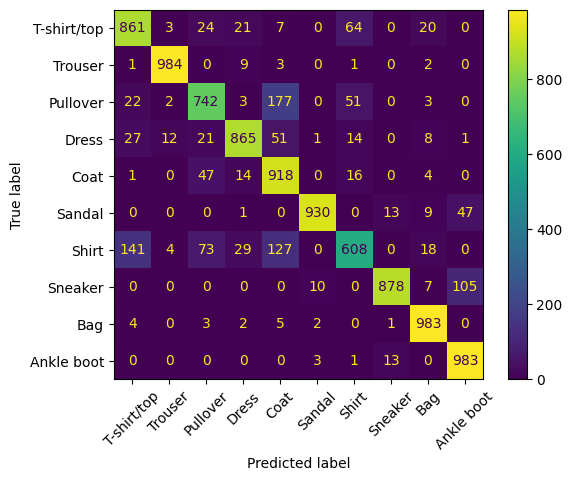

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45)
